In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import warnings; warnings.simplefilter('ignore')
import os, glob

pd.options.mode.chained_assignment = None  # default='warn'
plt.style.use('fivethirtyeight')

In [2]:
path = r'export'
all_files = glob.glob(os.path.join(path, "*.csv"))

df_from_each_file = (pd.read_csv(f) for f in all_files)
data = pd.concat(df_from_each_file, ignore_index=True)
data.sort_values(by=['pos', 'label'], inplace=True)

data['gen'] = data.groupby(by=['pos', 'label'])['is_budding'].cumsum()
data['id'] = 'P'+data['pos'].astype(str)+'L'+data['label'].astype(str)

In [3]:
reject_cells = pd.read_table('reject_cells.txt', sep='\t')

i1 = reject_cells.set_index('id').index
i2 = data.set_index('id').index

data = data[~i2.isin(i1)].set_index('id')

# Signal Whi5 Levels vs. G1 Phase Length

## All cells

In [10]:
whi5_data = data[data['zscore'] > 3]
whi5_data = data.groupby(by=['pos', 'label']).apply(lambda x: x[x['is_budding'] == 0])
whi5_data = whi5_data.groupby(by=['pos', 'label', 'gen'])['max_mean_9x'].max()

In [11]:
budding_curves = data[data['is_budding'] == 1]
g1_lengths = data[data['zscore'] > 3]
g1_lengths = data.groupby(by=['pos', 'label']).apply(lambda x: x[x['is_budding'] == 0])
g1_lengths = g1_lengths.sort_values(by=['pos', 'label', 'gen', 'max_mean_9x'], ascending=[True, True, True, False]).groupby(by=['pos', 'label', 'gen']).first()
g1_lengths['bud_time'] = budding_curves.set_index(['pos', 'label', 'gen'])['time']
g1_lengths.reset_index(inplace=True)
g1_lengths = g1_lengths[['pos', 'label', 'gen', 'time', 'bud_time']]
g1_lengths['bud_time'] = g1_lengths.reset_index().groupby(['pos', 'label'])['bud_time'].shift(-1)
g1_lengths['g1_interval'] = g1_lengths['bud_time'] - g1_lengths['time']
g1_lengths.dropna(axis=0, inplace=True)

full_data = pd.concat([whi5_data, g1_lengths.set_index(['pos', 'label', 'gen'])], axis=1)
full_data.dropna(axis=0, inplace=True)

Text(0.5,1,'Signal [Whi5] vs. G1 Phase Length')

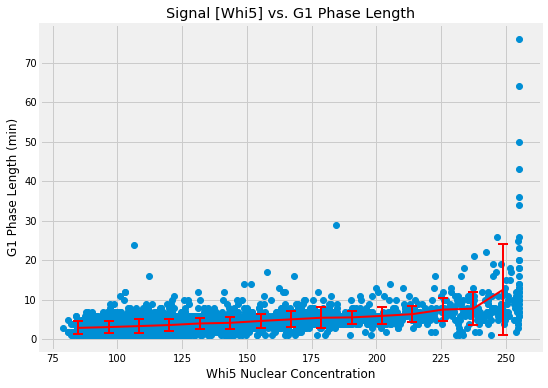

In [20]:
x = full_data['max_mean_9x']
y = full_data['g1_interval']
nbins = 15

n, _ = np.histogram(x, bins=nbins)
sy, _ = np.histogram(x, bins=nbins, weights=y)
sy2, _ = np.histogram(x, bins=nbins, weights=y*y)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)

plt.figure(figsize=(8, 6))
plt.plot(x, y, 'o')
plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='r-', zorder=10, linewidth=2, capsize = 5, capthick = 2)
plt.xlabel('Whi5 Nuclear Concentration')
plt.ylabel('G1 Phase Length (min)')
plt.title('Signal [Whi5] vs. G1 Phase Length')

Text(0.5,1,'Signal [Whi5] vs. G1 Phase Length')

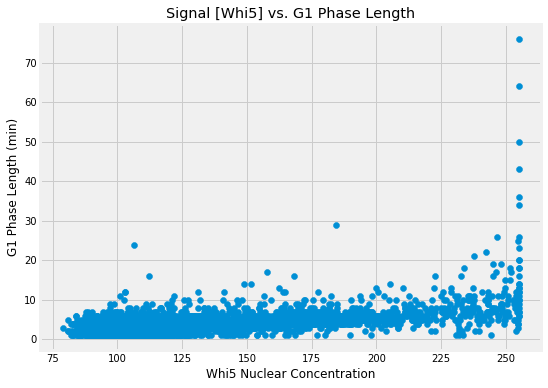

In [231]:
plt.figure(figsize=(8, 6))
plt.scatter(full_data['max_mean_9x'], full_data['g1_interval'])
plt.xlabel('Whi5 Nuclear Concentration')
plt.ylabel('G1 Phase Length (min)')
plt.title('Signal [Whi5] vs. G1 Phase Length')

## Old cells (last 3 generations)

In [8]:
budding_curves = data[data['is_budding'] == 1]
g1_lengths = data[data['zscore'] > 3]
g1_lengths = data.groupby(by=['pos', 'label']).apply(lambda x: x[x['is_budding'] == 0])
g1_lengths = g1_lengths.sort_values(by=['pos', 'label', 'gen', 'max_mean_9x'], ascending=[True, True, True, False]).groupby(by=['pos', 'label', 'gen']).first()
g1_lengths['bud_time'] = budding_curves.set_index(['pos', 'label', 'gen'])['time']
g1_lengths.reset_index(inplace=True)
g1_lengths = g1_lengths[['pos', 'label', 'gen', 'time', 'bud_time']]
g1_lengths['bud_time'] = g1_lengths.reset_index().groupby(['pos', 'label'])['bud_time'].shift(-1)
g1_lengths['g1_interval'] = g1_lengths['bud_time'] - g1_lengths['time']
g1_lengths.dropna(axis=0, inplace=True)

full_data = pd.concat([whi5_data, g1_lengths.set_index(['pos', 'label', 'gen'])], axis=1)
full_data.dropna(axis=0, inplace=True)
full_data = full_data.reset_index().groupby(by=['pos', 'label']).apply(lambda x: x[x['gen'] >= x['gen'].max() - 3])

Text(0.5,1,'Signal [Whi5] vs. G1 Phase Length in Old Cells')

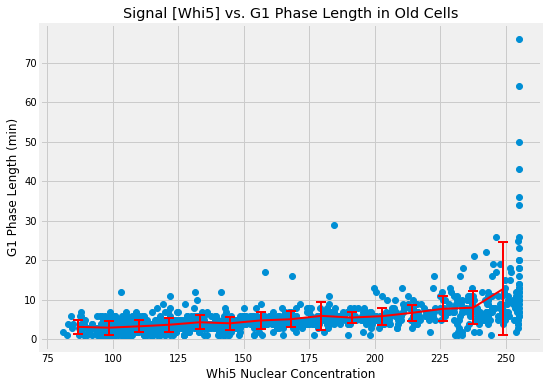

In [9]:
x = full_data['max_mean_9x']
y = full_data['g1_interval']
nbins = 15

n, _ = np.histogram(x, bins=nbins)
sy, _ = np.histogram(x, bins=nbins, weights=y)
sy2, _ = np.histogram(x, bins=nbins, weights=y*y)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)

plt.figure(figsize=(8, 6))
plt.plot(x, y, 'o')
plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='r-', zorder=10, linewidth=2, capsize = 5, capthick = 2)
plt.xlabel('Whi5 Nuclear Concentration')
plt.ylabel('G1 Phase Length (min)')
plt.title('Signal [Whi5] vs. G1 Phase Length in Old Cells')

Text(0.5,1,'Signal [Whi5] vs. G1 Phase Length in Old Cells')

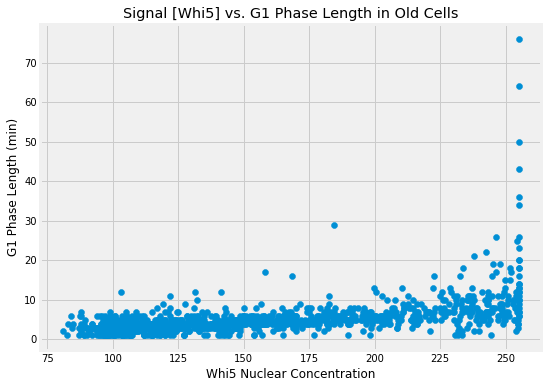

In [184]:
plt.figure(figsize=(8, 6))
plt.scatter(full_data['max_mean_9x'], full_data['g1_interval'])
plt.xlabel('Whi5 Nuclear Concentration')
plt.ylabel('G1 Phase Length (min)')
plt.title('Signal [Whi5] vs. G1 Phase Length in Old Cells')

## Young cells (first 8 generations)

In [251]:
g1_lengths = data[data['zscore'] > 3]
g1_lengths = data.groupby(by=['pos', 'label']).apply(lambda x: x[x['is_budding'] == 0])
g1_lengths = g1_lengths.sort_values(by=['pos', 'label', 'gen', 'max_mean_9x'], ascending=[True, True, True, False]).groupby(by=['pos', 'label', 'gen']).first()
g1_lengths['bud_time'] = budding_curves.set_index(['pos', 'label', 'gen'])['time']
g1_lengths.reset_index(inplace=True)
g1_lengths = g1_lengths[['pos', 'label', 'gen', 'time', 'bud_time']]
g1_lengths['bud_time'] = g1_lengths.reset_index().groupby(['pos', 'label'])['bud_time'].shift(-1)
g1_lengths['g1_interval'] = g1_lengths['bud_time'] - g1_lengths['time']
g1_lengths.dropna(axis=0, inplace=True)

full_data = pd.concat([whi5_data, g1_lengths.set_index(['pos', 'label', 'gen'])], axis=1)
full_data.dropna(axis=0, inplace=True)
full_data = full_data.reset_index().groupby(by=['pos', 'label']).head(8)

Text(0.5,1,'Signal [Whi5] vs. G1 Phase Length in Young Cells')

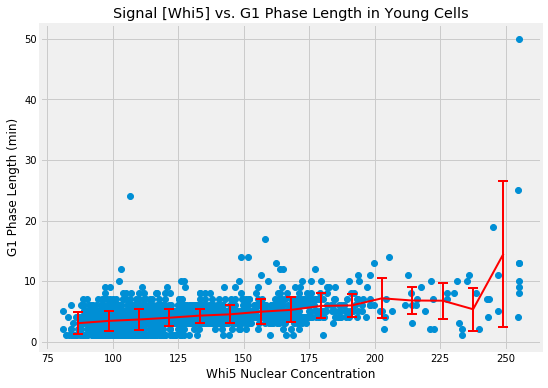

In [252]:
x = full_data['max_mean_9x']
y = full_data['g1_interval']
nbins = 15

n, _ = np.histogram(x, bins=nbins)
sy, _ = np.histogram(x, bins=nbins, weights=y)
sy2, _ = np.histogram(x, bins=nbins, weights=y*y)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)

plt.figure(figsize=(8, 6))
plt.plot(x, y, 'o')
plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='r-', zorder=10, linewidth=2, capsize = 5, capthick = 2)
plt.xlabel('Whi5 Nuclear Concentration')
plt.ylabel('G1 Phase Length (min)')
plt.title('Signal [Whi5] vs. G1 Phase Length in Young Cells')

Text(0.5,1,'Signal [Whi5] vs. G1 Phase Length in Young Cells')

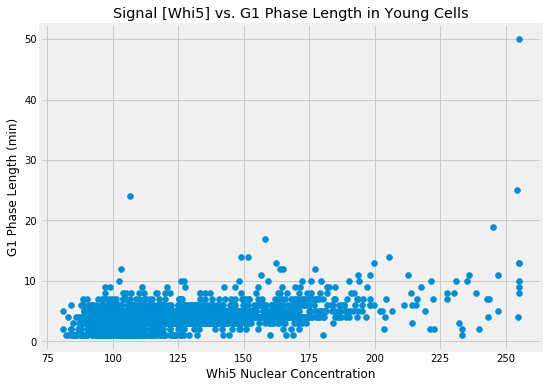

In [198]:
plt.figure(figsize=(8, 6))
plt.scatter(full_data['max_mean_9x'], full_data['g1_interval'])
plt.xlabel('Whi5 Nuclear Concentration')
plt.ylabel('G1 Phase Length (min)')
plt.title('Signal [Whi5] vs. G1 Phase Length in Young Cells')

# Total Cellular Whi5 Levels vs. G1 Phase Length

## All cells

In [63]:
whi5_data = data.groupby(by=['pos', 'label']).apply(lambda x: x[x['is_budding'] == 0])
whi5_data = whi5_data[whi5_data['zscore'] > 3]
whi5_data = whi5_data.groupby(by=['pos', 'label', 'gen'])['total_rfp'].max()

In [64]:
budding_curves = data[data['is_budding'] == 1]
g1_lengths = pd.concat([budding_curves.set_index(['pos', 'label', 'gen'])['time'].diff(), whi5_data], axis=1)
g1_lengths.rename(columns={'time':'g1_interval'}, inplace=True)
g1_lengths['total_rfp'] = g1_lengths.groupby(['pos', 'label'])['total_rfp'].shift(1)
g1_lengths = g1_lengths[(g1_lengths['total_rfp'] > 0) & (g1_lengths['g1_interval'] > 0)]
g1_lengths['g1_interval'] = g1_lengths['g1_interval'] * 10

(0, 300000)

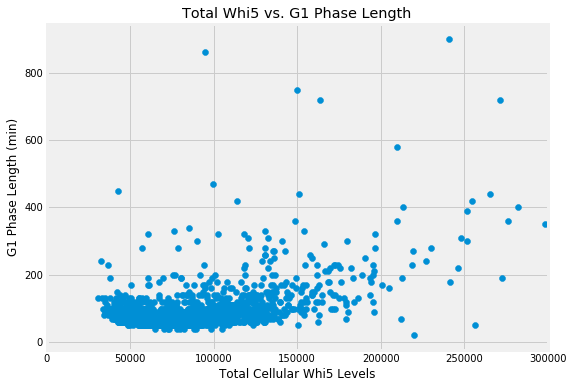

In [65]:
plt.figure(figsize=(8, 6))
plt.scatter(g1_lengths['total_rfp'], g1_lengths['g1_interval'])
plt.xlabel('Total Cellular Whi5 Levels')
plt.ylabel('G1 Phase Length (min)')
plt.title('Total Whi5 vs. G1 Phase Length')
plt.xlim(xmin=0,xmax=300000)

## Old cells (last 3 generations)

In [33]:
budding_curves = data[data['is_budding'] == 1]
g1_lengths = pd.concat([budding_curves.set_index(['pos', 'label', 'gen'])['time'].diff(), whi5_data], axis=1)
g1_lengths.rename(columns={'time':'g1_interval'}, inplace=True)
g1_lengths['total_rfp'] = g1_lengths.groupby(['pos', 'label'])['total_rfp'].shift(1)
g1_lengths = g1_lengths[(g1_lengths['total_rfp'] > 0) & (g1_lengths['g1_interval'] > 0)]
g1_lengths['g1_interval'] = g1_lengths['g1_interval'] * 10
g1_lengths = g1_lengths.reset_index().groupby(by=['pos', 'label']).apply(lambda x: x[x['gen'] >= x['gen'].max() - 3])
g1_lengths.drop(['pos', 'label', 'gen'], axis=1, inplace=True)

(0, 300000)

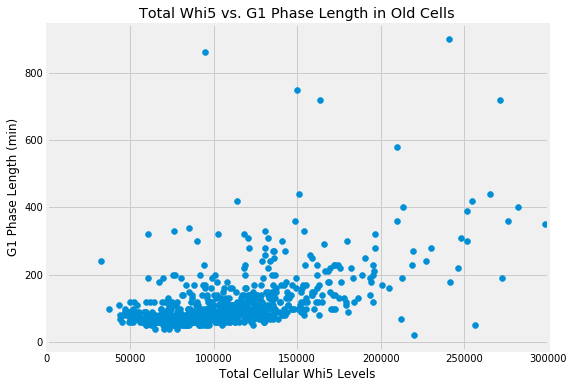

In [34]:
plt.figure(figsize=(8, 6))
plt.scatter(g1_lengths['total_rfp'], g1_lengths['g1_interval'])
plt.xlabel('Total Cellular Whi5 Levels')
plt.ylabel('G1 Phase Length (min)')
plt.title('Total Whi5 vs. G1 Phase Length in Old Cells')
plt.xlim(xmin=0,xmax=300000)

## Young cells (first 5 generations)

In [35]:
budding_curves = data[data['is_budding'] == 1]
g1_lengths = pd.concat([budding_curves.set_index(['pos', 'label', 'gen'])['time'].diff(), whi5_data], axis=1)
g1_lengths.rename(columns={'time':'g1_interval'}, inplace=True)
g1_lengths['total_rfp'] = g1_lengths.groupby(['pos', 'label'])['total_rfp'].shift(1)
g1_lengths = g1_lengths[(g1_lengths['total_rfp'] > 0) & (g1_lengths['g1_interval'] > 0)]
g1_lengths['g1_interval'] = g1_lengths['g1_interval'] * 10
g1_lengths = g1_lengths.reset_index().groupby(by=['pos', 'label']).head(5)
g1_lengths.drop(['pos', 'label', 'gen'], axis=1, inplace=True)

(0, 300000)

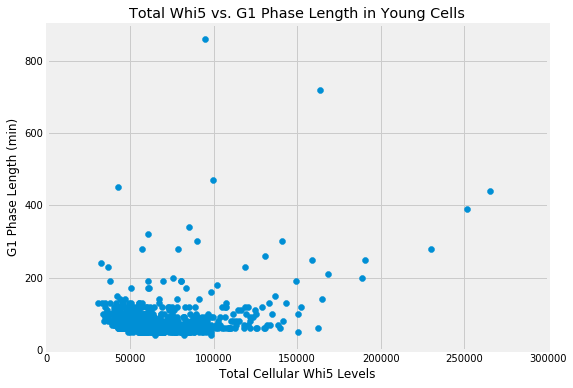

In [36]:
plt.figure(figsize=(8, 6))
plt.scatter(g1_lengths['total_rfp'], g1_lengths['g1_interval'])
plt.xlabel('Total Cellular Whi5 Levels')
plt.ylabel('G1 Phase Length (min)')
plt.title('Total Whi5 vs. G1 Phase Length in Young Cells')
plt.xlim(xmin=0, xmax=300000)

# Total Nuclear Whi5 Levels vs. G1 Phase Length

## All cells

In [66]:
whi5_data = data.groupby(by=['pos', 'label']).apply(lambda x: x[x['is_budding'] == 0])
whi5_data = whi5_data[whi5_data['zscore'] > 3]
whi5_data = whi5_data.groupby(by=['pos', 'label', 'gen'])['total_nucleic'].max()

In [67]:
budding_curves = data[data['is_budding'] == 1]
g1_lengths = pd.concat([budding_curves.set_index(['pos', 'label', 'gen'])['time'].diff(), whi5_data], axis=1)
g1_lengths.rename(columns={'time':'g1_interval'}, inplace=True)
g1_lengths['total_nucleic'] = g1_lengths.groupby(['pos', 'label'])['total_nucleic'].shift(1)
g1_lengths = g1_lengths[(g1_lengths['total_nucleic'] > 0) & (g1_lengths['g1_interval'] > 0)]
g1_lengths['g1_interval'] = g1_lengths['g1_interval'] * 10

(0, 100000)

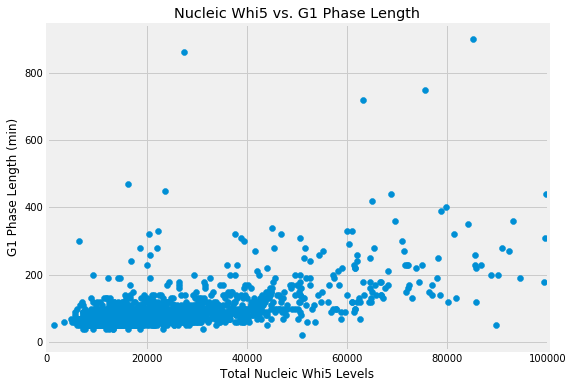

In [68]:
plt.figure(figsize=(8, 6))
plt.scatter(g1_lengths['total_nucleic'], g1_lengths['g1_interval'])
plt.xlabel('Total Nucleic Whi5 Levels')
plt.ylabel('G1 Phase Length (min)')
plt.title('Nucleic Whi5 vs. G1 Phase Length')
plt.xlim(xmin=0,xmax=100000)

## Old cells (last 3 generations)

In [45]:
budding_curves = data[data['is_budding'] == 1]
g1_lengths = pd.concat([budding_curves.set_index(['pos', 'label', 'gen'])['time'].diff(), whi5_data], axis=1)
g1_lengths.rename(columns={'time':'g1_interval'}, inplace=True)
g1_lengths['total_nucleic'] = g1_lengths.groupby(['pos', 'label'])['total_nucleic'].shift(1)
g1_lengths = g1_lengths[(g1_lengths['total_nucleic'] > 0) & (g1_lengths['g1_interval'] > 0)]
g1_lengths['g1_interval'] = g1_lengths['g1_interval'] * 10
g1_lengths = g1_lengths.reset_index().groupby(by=['pos', 'label']).apply(lambda x: x[x['gen'] >= x['gen'].max() - 3])
g1_lengths.drop(['pos', 'label', 'gen'], axis=1, inplace=True)

(0, 100000)

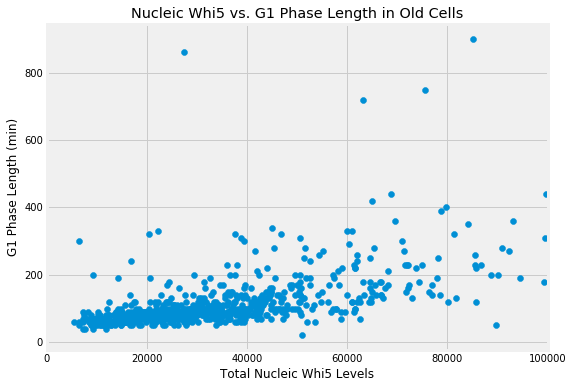

In [46]:
plt.figure(figsize=(8, 6))
plt.scatter(g1_lengths['total_nucleic'], g1_lengths['g1_interval'])
plt.xlabel('Total Nucleic Whi5 Levels')
plt.ylabel('G1 Phase Length (min)')
plt.title('Nucleic Whi5 vs. G1 Phase Length in Old Cells')
plt.xlim(xmin=0,xmax=100000)

## Young cells (first 5 generations)

In [42]:
budding_curves = data[data['is_budding'] == 1]
g1_lengths = pd.concat([budding_curves.set_index(['pos', 'label', 'gen'])['time'].diff(), whi5_data], axis=1)
g1_lengths.rename(columns={'time':'g1_interval'}, inplace=True)
g1_lengths['total_nucleic'] = g1_lengths.groupby(['pos', 'label'])['total_nucleic'].shift(1)
g1_lengths = g1_lengths[(g1_lengths['total_nucleic'] > 0) & (g1_lengths['g1_interval'] > 0)]
g1_lengths['g1_interval'] = g1_lengths['g1_interval'] * 10
g1_lengths = g1_lengths.reset_index().groupby(by=['pos', 'label']).head(5)
g1_lengths.drop(['pos', 'label', 'gen'], axis=1, inplace=True)

(0, 100000)

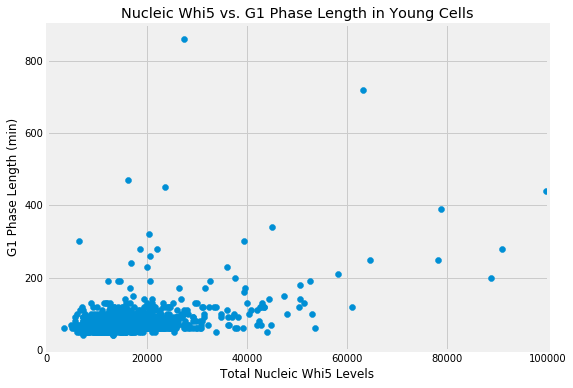

In [44]:
plt.figure(figsize=(8, 6))
plt.scatter(g1_lengths['total_nucleic'], g1_lengths['g1_interval'])
plt.xlabel('Total Nucleic Whi5 Levels')
plt.ylabel('G1 Phase Length (min)')
plt.title('Nucleic Whi5 vs. G1 Phase Length in Young Cells')
plt.xlim(xmin=0, xmax=100000)

# My Data

In [2]:
data = pd.read_table('exp249.txt', sep='\t')
data['min'] = data['time'] * 10

data['above_thresh'] = data.groupby(by=['pos', 'label']).apply(lambda x: x['signal'] >= x['signal'].median() * 1.3).reset_index()['signal'].astype(int)

data_grouped = data.groupby(by=['pos', 'label'])

data['id'] = 'P' + data['pos'].astype(str) + 'L' + data['label'].astype(str)

In [6]:
avg_lifespan = (data_grouped['min'].last() - data_grouped['min'].first() + 10).mean()
print('The average lifespan per cell is approximately %f mins.' % avg_lifespan)

The average lifespan per cell is approximately 429.052579 mins.


## Examples

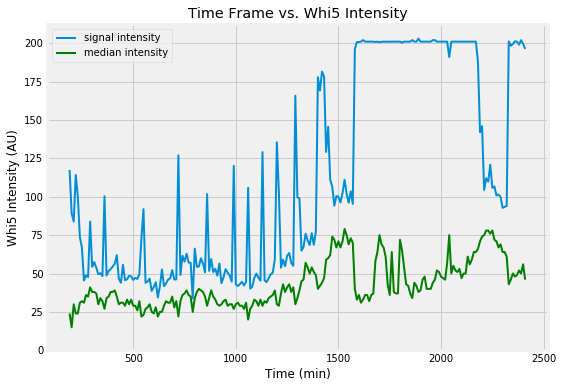

In [6]:
ex = data[data['id'] == 'P5L1']
plt.figure(figsize=(8, 6))
plt.plot(ex['min'], ex['signal'], linewidth = 2, label='signal intensity')
plt.plot(ex['min'], ex['median'], linewidth = 2, c='g', label='median intensity')
plt.ylim(ymin=0)
plt.xlabel('Time (min)')
plt.ylabel('Whi5 Intensity (AU)')
plt.title('Time Frame vs. Whi5 Intensity')

plt.legend()

## How Whi5 Nuclear Concentration Changes over Time

(0, 123.3905994208115)

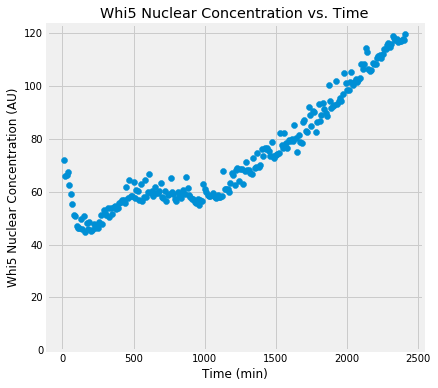

In [15]:
plt.figure(figsize=(6, 6))
plt.scatter(data.groupby(['min']).mean().index, data.groupby(['min']).mean()['signal'])
plt.title('Whi5 Nuclear Concentration vs. Time')
plt.xlabel('Time (min)')
plt.ylabel('Whi5 Nuclear Concentration (AU)')
plt.ylim(ymin=0)

## Export cell data in research paper

In [718]:
paper_cells = pd.read_table('cells.txt', sep='\t')

i1 = paper_cells.set_index('id').index
i2 = data.set_index('id').index

paper_data = data[i2.isin(i1)].set_index('id')
paper_data.drop(['pos', 'label', 'above_thresh', 'thresh_count'], axis=1, inplace=True)
paper_data['paper_label'] = paper_cells.set_index('id')['paper_label']

paper_data.to_csv('paper_data.txt', sep='\t')